In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from patsy import bs, dmatrix
from permutation import *

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist()
X_train = np.reshape(X_train,(-1,28,28,1)) 
X_test = np.reshape(X_test,(-1,28,28,1))

In [3]:
coor = []
for i in range(28):
    for j in range(28):
        coor.append([i/27, j/27])
coor = np.array(coor, dtype='float32')

def extract_points(img, num = 400):
    N = img.shape[0] 
    M = img.shape[1] * img.shape[2]
    res = np.zeros([N,num,3])
    for i in range(N):
        weight = img[i].reshape((-1,))
        ind = np.random.choice(M, num, p=weight/np.sum(weight))
        res[i,:,:2] = coor[ind,:]
        res[i,:,2] = weight[ind]
    return res

In [4]:
P_train = extract_points(X_train)
P_test = extract_points(X_test)
P_train.shape, P_test.shape

((55000, 400, 3), (10000, 400, 3))

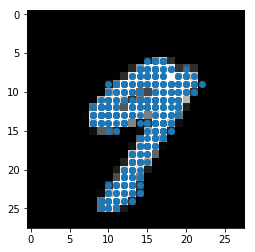

In [5]:
plt.imshow(X_test[20].reshape(28, 28),cmap='gray')
plt.scatter(P_test[20][:,1]*27,P_test[20][:,0]*27)
plt.show()

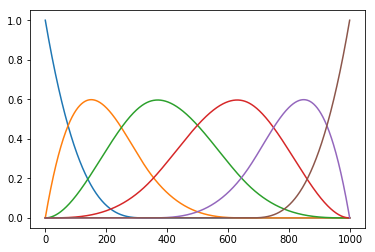

In [9]:
# plt.plot(BS(df=7)(tf.cast([np.linspace(0,1,1000)],dtype='float32')).numpy()[0])
plt.plot(bs(np.linspace(0,1,1000),df=6,include_intercept=True))
plt.show()

In [44]:
def pc_loss(P, points):
    weight = P[:,:,2]; Pt = P[:,:,:2]
    dist = tf.einsum("nud,ntd->nut", Pt**2, tf.ones_like(points)) -\
           2 * tf.einsum("nud,ntd->nut", Pt, points) +\
           tf.einsum("nud,ntd->nut", tf.ones_like(Pt), points**2)
    weight_dist = tf.expand_dims(
        tf.cast(weight < 0.95, dtype='float32'),axis=2) + dist
    min_dist = tf.reduce_min(dist, axis = 2)
    min_rev = tf.reduce_min(weight_dist, axis = 1)
    
    losses = tf.reduce_mean(tf.reduce_sum(weight * min_dist, axis=1))
    losses += tf.reduce_mean(tf.reduce_sum(min_rev, axis=1))
    return losses 
def len_loss(X, points):
    return tf.reduce_mean(tf.reduce_sum(
                tf.sqrt(
                    tf.clip_by_value(
                        (points[:,:-1,0] - points[:,1:,0])**2 +\
                        (points[:,:-1,1] - points[:,1:,1])**2,
                        1e-7, 1e7)
                ),axis=1))
def smooth_loss(df=7):
    def loss(X, curve):
        A = np.diff(
            bs(np.linspace(0,1,1000),df=df,include_intercept=True),
            axis=0) / 1e-3
        A = tf.cast(A, dtype='float32')
        d2t = tf.einsum('ab,nbc->nac',A,curve)
        return tf.reduce_mean(
                tf.reduce_max(
                 tf.reduce_sum(tf.abs(d2t),axis = 2),
                 axis = 1)
               )
    return loss
def sq_loss(P, bias):
    return tf.reduce_mean(tf.reduce_sum(bias**2,axis=(1,2)))

In [70]:
def SetDecoder(df=7,nc=3,num=400):
    inputs = keras.Input(shape=[num,3+nc*2])
    
    x = tf.reshape(inputs,(-1,3+nc*2))
    x = layers.Dense(128,activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    score = layers.Dense(32,activation='relu')(x)
    score = tf.reshape(score,(-1,num,32))
    score = tf.reduce_mean(score, axis=1)
    score = layers.BatchNormalization()(score)
    state = layers.Dense(128,activation='relu')(score)
    state = layers.Dropout(0.5)(state)
    state = layers.Dense(128,activation='tanh')(state)
    para = layers.Dense(2*df)(state)
    para = tf.reshape(para,(-1,df,2))
    
    model = keras.Model(inputs=inputs, outputs=para,name='setdecoder')
    model.df, model.nc = df, nc
    return model

def SetEncoder(nc,num=400):
    inputs = keras.Input(shape=[num,3])
    init = tf.random_normal_initializer(stddev=1e-1)
    x = tf.reshape(inputs,(-1,3))
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    score = layers.Dense(64,activation='sigmoid')(x)
    score = tf.reshape(score,(-1,num,64))
    score = tf.reduce_mean(score, axis=1)
    score = layers.BatchNormalization()(score)
    state = layers.Dense(128,activation='relu',
                         kernel_initializer=init)(score)
    constn = layers.Dense(nc*2,activation='sigmoid')(state)
    constn = tf.reshape(constn,(-1,nc,2))
    
    model = keras.Model(inputs=inputs, outputs=constn,name='setencoder')
    return model

def ParaAutoEncoder(encoder,decoder,num=400):
    inputs = keras.Input(shape=[num,3])
    
    constrain = encoder(inputs)
    nc, df = decoder.nc, decoder.df
    flat = tf.reshape(constrain,(-1,1,2*nc))
    flat_tile = tf.tile(flat,(1,num,1))
    Wcn = bs(np.linspace(0,1,nc),df=df,include_intercept=True)
    Wc = tf.constant(Wcn,dtype='float32')
    P = tf.gather(inputs,[0,1],axis=2)

    basis = bs(np.linspace(0,1,num),df=df,include_intercept=True)
    basisT = np.transpose(basis)
    DTDinv = np.linalg.inv(basisT@basis + 1e-5*np.eye(df))
    DTDinv = tf.cast(DTDinv, dtype='float32')
    curve0 = decoder(tf.concat([inputs,flat_tile],axis=2))
    bias = tf.einsum("sd,ndk->nsk",Wc,curve0) - constrain
    Winv = tf.matmul(tf.matmul(Wc,DTDinv),tf.transpose(Wc,(1,0)))
    Winv = tf.linalg.inv(Winv + 1e-5*tf.eye(nc))
    Wp = tf.matmul(DTDinv,tf.transpose(Wc,(1,0)))
    curve1 = curve0 - tf.einsum('ab,nbc->nac',tf.matmul(Wp,Winv),bias)
    points = tf.einsum('pd,ndk->npk', 
                       tf.cast(basis,dtype='float32'), 
                       curve1)
    
    model = keras.Model(inputs=inputs, outputs=[points,points,curve1,bias],name='PAE')
    return model

In [80]:
keras.backend.clear_session()
encoder,decoder = SetEncoder(2),SetDecoder(6,2)
PAE = ParaAutoEncoder(encoder,decoder)
PAE.summary()

Model: "PAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 3)]     0                                            
__________________________________________________________________________________________________
setencoder (Model)              (None, 2, 2)         18372       input_3[0][0]                    
__________________________________________________________________________________________________
Reshape_198 (TensorFlowOpLayer) [(None, 1, 4)]       0           setencoder[1][0]                 
__________________________________________________________________________________________________
Tile_4 (TensorFlowOpLayer)      [(None, 400, 4)]     0           Reshape_198[0][0]                
________________________________________________________________________________________________

In [ ]:
encoder.trainable, decoder.trainable = 1, 1
PAE.compile(keras.optimizers.Adam(1e-3), loss=[pc_loss,len_loss,smooth_loss(6),sq_loss],
            loss_weights=[1,1,1,0])
PAE.fit(P_train, [P_train,P_train,P_train,P_train], epochs=1, 
        batch_size=128, shuffle=True,
        validation_data=(P_test, [P_test,P_test,P_test,P_test]),
        callbacks=[keras.callbacks.TensorBoard(log_dir='tmp/autoencoder')])
for it in range(5):
    encoder.trainable, decoder.trainable = 0, 1
    PAE.compile(keras.optimizers.Adam(1e-3), loss=[pc_loss,len_loss,smooth_loss(6),sq_loss],
                loss_weights=[1,2e-1,5e-1,1])
    PAE.fit(P_train, [P_train,P_train,P_train,P_train], epochs=3, 
            batch_size=128, shuffle=True,
            validation_data=(P_test, [P_test,P_test,P_test,P_test]),
            callbacks=[keras.callbacks.TensorBoard(log_dir='tmp/autoencoder')])
    encoder.trainable, decoder.trainable = 1, 0
    PAE.compile(keras.optimizers.Adam(1e-3), loss=[pc_loss,len_loss,smooth_loss(6),sq_loss],
                loss_weights=[1,0,0,-1])
    PAE.fit(P_train, [P_train,P_train,P_train,P_train], epochs=2, 
            batch_size=128, shuffle=True,
            validation_data=(P_test, [P_test,P_test,P_test,P_test]),
            callbacks=[keras.callbacks.TensorBoard(log_dir='tmp/autoencoder')])

Train on 55000 samples, validate on 10000 samples


W0512 19:58:21.172391 139999817123648 tf_logging.py:161] Model failed to serialize as JSON. Ignoring... ('Not JSON Serializable:', b'\n%setencoder_22/Reshape_192/Reshape_192\x12\x07Reshape\x1a\ninput_1_22\x1a\x11Reshape_192/shape*\x07\n\x01T\x12\x020\x01*\x0c\n\x06Tshape\x12\x020\x03')


55000/55000 [==============================] - 37s 671us/sample - loss: 13.4488 - transpose_62_loss: 1.3948 - sub_15_loss: 3.9241 - sub_14_loss: 0.8617 - val_loss: 23.0257 - val_transpose_62_loss: 1.3906 - val_sub_15_loss: 7.0139 - val_sub_14_loss: 0.8604
Train on 55000 samples, validate on 10000 samples


W0512 19:59:09.903125 139999817123648 tf_logging.py:161] Model failed to serialize as JSON. Ignoring... ('Not JSON Serializable:', b'\n%setencoder_22/Reshape_192/Reshape_192\x12\x07Reshape\x1a\ninput_1_22\x1a\x11Reshape_192/shape*\x07\n\x01T\x12\x020\x01*\x0c\n\x06Tshape\x12\x020\x03')


Epoch 1/3
55000/55000 [==============================] - 33s 594us/sample - loss: 4.5217 - transpose_62_loss: 1.4601 - sub_15_loss: 2.9904 - sub_14_loss: 0.0591 - val_loss: 4.2232 - val_transpose_62_loss: 1.2502 - val_sub_15_loss: 2.7472 - val_sub_14_loss: 0.0214
Epoch 2/3
55000/55000 [==============================] - 30s 542us/sample - loss: 4.1103 - transpose_62_loss: 1.4287 - sub_15_loss: 2.9709 - sub_14_loss: 0.0168 - val_loss: 3.9946 - val_transpose_62_loss: 1.2802 - val_sub_15_loss: 2.8108 - val_sub_14_loss: 0.0055
Epoch 3/3
55000/55000 [==============================] - 27s 499us/sample - loss: 4.0298 - transpose_62_loss: 1.4361 - sub_15_loss: 2.9887 - sub_14_loss: 0.0103 - val_loss: 3.8324 - val_transpose_62_loss: 1.4056 - val_sub_15_loss: 2.9127 - val_sub_14_loss: 0.0042
Train on 55000 samples, validate on 10000 samples


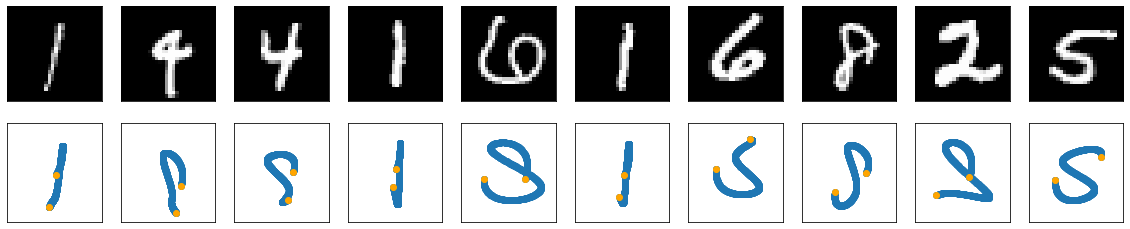

In [79]:
decoded_imgs = PAE.predict(P_test)

n = 10
plt.figure(figsize=(20, 4))
ind = np.random.randint(0, 10000, 10)
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[ind[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display points
    ax = plt.subplot(2, n, i + n)
    xs = decoded_imgs[0][ind[i-1]][:,0]
    ys = decoded_imgs[0][ind[i-1]][:,1]
    plt.scatter(ys, -xs)
    plt.scatter(ys[[0,-1]], -xs[[0,-1]], c='orange')
    plt.xlim(0,1); plt.ylim(-1,0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [8]:
def sample_init(X, df=7):
    return np.random.uniform(0,1,(X.shape[0],df,2))

Cinit_train = sample_init(X_train)
Cinit_test = sample_init(X_test)

Cinit_train.shape, Cinit_test.shape

((55000, 7, 2), (10000, 7, 2))

In [9]:
def proj_model(df=7):
    inputsP = keras.Input(shape=[2,])
    inputsC = keras.Input(shape=[df,2])
    
    basis = bs(np.linspace(0,1,1000),df=df,include_intercept=True)
    basis = tf.cast(basis,dtype='float32')
    curve = tf.einsum("nf,bfd->bnd",basis,inputsC)
    dist = tf.reduce_sum((tf.reshape(inputsP,(-1,1,2)) - curve)**2,axis=2)
    dist_nl = (dist-tf.reshape(tf.reduce_min(dist,axis=1),(-1,1))) + 1e-15
    dist_nl = dist_nl / tf.reshape(tf.reduce_max(dist_nl,axis=1)+1e-15,(-1,1))
    score = tf.reshape(tf.exp(-10*dist_nl**0.5),(-1,10))
    
    x = layers.Dense(20,activation='relu')(score)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    x = tf.reshape(x,(-1,1000,2));x=tf.reshape(x,(-1,200))
    x = layers.Dense(100,activation='sigmoid')(x)
    x = tf.reshape(x,(-1,1000))
    x = layers.Dense(1,activation='sigmoid')(x)
    
    return keras.Model(inputs=[inputsP,inputsC], 
                       outputs=x)

In [224]:
keras.backend.clear_session()

pj = proj_model(df=6)
pj.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6, 2)]       0                                            
__________________________________________________________________________________________________
transpose_362 (TensorFlowOpLaye [(6, None, 2)]       0           input_2[0][0]                    
__________________________________________________________________________________________________
Shape_170 (TensorFlowOpLayer)   [(3,)]               0           transpose_362[0][0]              
__________________________________________________________________________________________________
strided_slice_170 (TensorFlowOp [None]               0           Shape_170[0][0]                  
______________________________________________________________________________________________

In [225]:
def true_ts(P,C,df=7):
    basis = bs(np.linspace(0,1,1000),df=df,include_intercept=True) 
    pts = np.tensordot(C,basis,axes=(1,1)) 
    dist = np.sum((pts - np.reshape(P,(-1,2,1)))**2,axis=1)
    return np.argmin(dist, axis=1)/999

In [228]:
df = 6
PJ_P_train = np.random.uniform(0,1,(100000,2))
PJ_C_train = np.tile(np.random.uniform(0,1,(1000,df,2)),(100,1,1))
PJ_true_train = true_ts(PJ_P_train, PJ_C_train, df=df)

PJ_P_test = np.random.uniform(0,1,(20000,2))
PJ_C_test = np.random.uniform(0,1,(20000,df,2))
PJ_true_test = true_ts(PJ_P_test, PJ_C_test, df=df)

pj.compile(keras.optimizers.Adam(1e-3), loss='mse')
pj.fit([PJ_P_train,PJ_C_train], PJ_true_train, epochs=50, 
        batch_size=128, shuffle=True,
        validation_data=([PJ_P_test,PJ_C_test], PJ_true_test),
        callbacks=[keras.callbacks.TensorBoard(log_dir='tmp/autoencoder')])

Train on 100000 samples, validate on 20000 samples


W0511 16:50:57.389924 140128811296576 tf_logging.py:161] Model failed to serialize as JSON. Ignoring... ('Not JSON Serializable:', b'\n\rtranspose_362\x12\tTranspose\x1a\ninput_2_33\x1a\x12transpose_362/perm*\x07\n\x01T\x12\x020\x01*\x0b\n\x05Tperm\x12\x020\x03')


Epoch 1/50
100000/100000 [==============================] - 3s 27us/sample - loss: 7.5002e-04 - val_loss: 5.6583e-04
Epoch 2/50
100000/100000 [==============================] - 2s 23us/sample - loss: 6.7001e-04 - val_loss: 5.6089e-04
Epoch 3/50
100000/100000 [==============================] - 2s 24us/sample - loss: 6.7512e-04 - val_loss: 7.3174e-04
Epoch 4/50
100000/100000 [==============================] - 2s 25us/sample - loss: 6.4777e-04 - val_loss: 5.3510e-04
Epoch 5/50
100000/100000 [==============================] - 2s 24us/sample - loss: 6.6495e-04 - val_loss: 4.1907e-04
Epoch 6/50
100000/100000 [==============================] - 2s 24us/sample - loss: 6.0132e-04 - val_loss: 5.4165e-04
Epoch 7/50
 33792/100000 [=========>....................] - ETA: 1s - loss: 6.8248e-04

KeyboardInterrupt: 

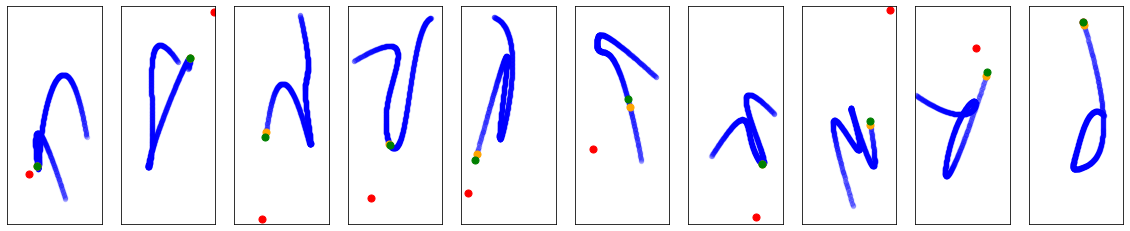

In [230]:
decoded_imgs = pj.predict([PJ_P_test,PJ_C_test])

n = 10; df = 6
plt.figure(figsize=(20, 4))
ind = np.random.randint(0, 10000, 10)
for i in range(1,n+1):
    # display original
    ax = plt.subplot(1, n, i)
    oxy = PJ_P_test[ind[i-1]]
    plt.scatter(oxy[0], oxy[1], c='red', s=50)
    
    curve = PJ_C_test[ind[i-1]]
    pts = bs(np.linspace(0,1,1000),df=df,include_intercept=True) @ curve
    xs = pts[:,0]; ys = pts[:,1]
    plt.scatter(xs, ys, alpha=0.2, c='blue', s=20)
    
    ts = decoded_imgs[ind[i-1],0]
    ts_true = PJ_true_test[ind[i-1]]
    basis = bs(np.linspace(0,1,1000),df=df,include_intercept=True) 
    basis_model = basis[int(round(ts*999)),:]
    basis_true = basis[int(round(ts_true*999)),:]
    pt = (basis_model @ curve).reshape((2,))
    pt_true = (basis_true @ curve).reshape((2,))
    plt.scatter(pt[0], pt[1], c='orange', s=50)
    plt.scatter(pt_true[0], pt_true[1], c='green', s=50)
    plt.xlim(0,1); plt.ylim(0,1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [253]:
def curve_init(df,nc):
    W = bs(np.linspace(0,1,nc),df=df,include_intercept=True)
    A = np.diff(
        bs(np.linspace(0,1,1000),df=df,include_intercept=True),
        axis=0) / 1e-3
    A = np.diff(A, axis=0) / 1e-2
    ATAW = np.concatenate([A.T @ A,W],axis=0)
    WTO = np.concatenate([W.T,np.zeros([nc,nc])],axis=0)
    D = np.concatenate([ATAW, WTO],axis=1)
    Dinv = np.linalg.inv(D)[:df,-nc:]
    
    return tf.cast(Dinv,dtype='float32')

def SetEncoder(nc,num=400):
    inputs = keras.Input(shape=[num,3])
    init = tf.random_normal_initializer(stddev=1e-1)
    x = tf.reshape(inputs,(-1,3))
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    score = layers.Dense(64,activation='sigmoid')(x)
    score = tf.reshape(score,(-1,num,64))
    score = tf.reduce_mean(score, axis=1)
    score = layers.BatchNormalization()(score)
    state = layers.Dense(128,activation='relu',
                         kernel_initializer=init)(score)
    constn = layers.Dense(nc*2,activation='sigmoid')(state)
    constn = tf.reshape(constn,(-1,nc,2))
    
    model = keras.Model(inputs=inputs, outputs=constn,name='setencoder')
    return model

def projPC(proj_model, set_encoder,
           df=7, nc = 3, niter=5, num=400):
    
    proj_model.trainable = False
    
    inputs = keras.Input(shape=[num,3])
    Wcn = bs(np.linspace(0,1,nc),df=df,include_intercept=True)
    Wc = tf.constant(Wcn,dtype='float32')
    P = tf.gather(inputs,[0,1],axis=2)
    Basis = BS(df=df)
    
    constrain = set_encoder(inputs)
    
    Dinv = curve_init(df, nc)
    curve = tf.einsum('dc,nck->ndk',Dinv,constrain)
    Ubasis = tf.cast(bs(np.linspace(0,1,num),df=df,
                    include_intercept=True),dtype='float32')
    Upoints = tf.einsum('pd,ndk->npk', Ubasis, curve)
    points = Upoints
    
    for i in range(niter):
        cxy = tf.reshape(curve,(-1,1,df,2))
        cxy = tf.tile(cxy,(1,num,1,1))
        ts = proj_model([tf.reshape(P,(-1,2)), tf.reshape(cxy,(-1,df,2))])
        ts = tf.reshape(ts, (-1,num))
        ts_min = tf.reduce_min(ts,axis=1)
        ts_max = tf.reduce_max(ts,axis=1)
        ts_nl = ts - tf.reshape(ts_min,(-1,1))
        ts_nl = ts_nl / tf.reshape(ts_max-ts_min+1e-15,(-1,1))
        
        basis = Basis(ts_nl)
        basisT = tf.transpose(basis,(0,2,1))
        DTDinv = tf.linalg.inv(tf.matmul(basisT,basis) +\
                1e-3*tf.reshape(tf.eye(df),(1,df,df)))
        PT = tf.matmul(basisT, P)
        curve0 = tf.matmul(DTDinv, PT)
        bias = tf.einsum("sd,ndk->nsk",Wc,curve0) - constrain
        Winv = tf.einsum('nab,bc->nac',tf.einsum("sd,ndk->nsk",Wc,DTDinv),
                         tf.transpose(Wc,(1,0)))
        Winv = tf.linalg.inv(Winv +\
                1e-3*tf.reshape(tf.eye(nc),(1,nc,nc)))
        Wp = tf.einsum('nab,bc->nac',DTDinv,tf.transpose(Wc,(1,0)))
        curve1 = curve0 - tf.matmul(tf.matmul(Wp,Winv),bias)
        curve = curve1
        points = tf.matmul(basis, curve)
        Upoints = tf.einsum('pd,ndk->npk', Ubasis, curve)
        
    return keras.Model(inputs=inputs, outputs=[points,Upoints,curve], 
                       name='princurve')

In [276]:
def pc_loss(P, points):
    weight = P[:,:,2]; Pt = P[:,:,:2]
    dist = tf.einsum("nud,ntd->nut", Pt**2, tf.ones_like(points)) -\
           2 * tf.einsum("nud,ntd->nut", Pt, points) +\
           tf.einsum("nud,ntd->nut", tf.ones_like(Pt), points**2)
    weight_dist = tf.expand_dims(
        tf.cast(weight < 0.95, dtype='float32'),axis=2) + dist
    min_dist = tf.reduce_min(dist, axis = 2)
    min_rev = tf.reduce_min(weight_dist, axis = 1)
    
    losses = tf.reduce_mean(tf.reduce_sum(weight * min_dist, axis=1))
    losses += tf.reduce_mean(tf.reduce_sum(min_rev, axis=1))
    return losses 
def sq_loss(P, points):
    weight = P[:,:,2]; Pt = P[:,:,:2]
    return tf.reduce_mean(weight * tf.reduce_sum((Pt - points)**2, axis=2))
def len_loss(X, points):
    return tf.reduce_mean(
           tf.reduce_sum(tf.sqrt(tf.clip_by_value(
                        (points[:,:-1,0] - points[:,1:,0])**2 +\
                        (points[:,:-1,1] - points[:,1:,1])**2,
                        1e-7, 1e7)),axis=1))

In [269]:
keras.backend.clear_session()
# encoder = SetEncoder(nc=3)
pc_curve = projPC(pj,encoder,
                  df=6,nc=3,niter=2)
# pc_curve.summary()

In [270]:
pc_curve.compile(keras.optimizers.Adam(1e-4), loss=[sq_loss,len_loss,len_loss],
                 loss_weights=[1,1,0])
pc_curve.fit(P_train, [P_train,P_train,P_train], epochs=50, 
        batch_size=64, shuffle=True,
        validation_data=(P_test, [P_test,P_test,P_test]),
        callbacks=[keras.callbacks.TensorBoard(log_dir='tmp/autoencoder')])

Train on 55000 samples, validate on 10000 samples


W0511 17:14:45.171509 140128811296576 tf_logging.py:161] Model failed to serialize as JSON. Ignoring... ('Not JSON Serializable:', b'\n?setencoder_61/Reshape_820/setencoder_60/Reshape_820/Reshape_820\x12\x07Reshape\x1a\ninput_1_62\x1a\x11Reshape_820/shape*\x07\n\x01T\x12\x020\x01*\x0c\n\x06Tshape\x12\x020\x03')


Epoch 1/50
55000/55000 [==============================] - 436s 8ms/sample - loss: 1.2122 - MatMul_441_loss: 0.0042 - transpose_541_loss: 1.2080 - sub_135_loss: 1.6176 - val_loss: 1.2066 - val_MatMul_441_loss: 0.0044 - val_transpose_541_loss: 1.2027 - val_sub_135_loss: 1.6169
Epoch 2/50
10176/55000 [====>.........................] - ETA: 5:30 - loss: 1.2282 - MatMul_441_loss: 0.0046 - transpose_541_loss: 1.2237 - sub_135_loss: 1.6476

KeyboardInterrupt: 

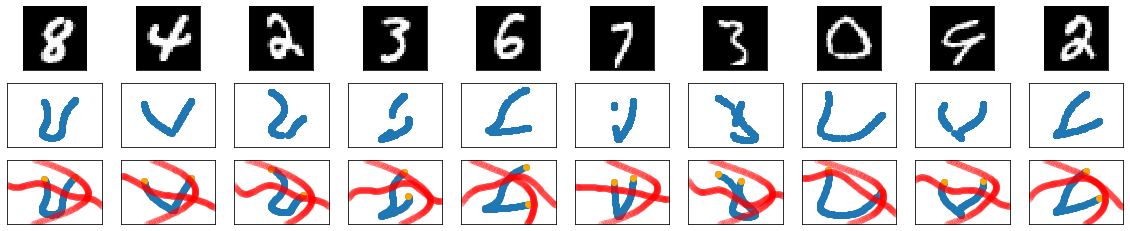

In [272]:
n = 10; df=6
plt.figure(figsize=(20, 4))
ind = np.random.randint(0, 10000, 10)
decoded_imgs = pc_curve.predict(P_test[ind])
for i in range(1,n+1):
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(X_test[ind[i-1]].reshape(28, 28))
    plt.gray()
    
#     curve = Cinit_test[ind[i-1]]
#     pts = bs(np.linspace(0,1,100),df=df,include_intercept=True) @ curve
#     xs = pts[:,0]
#     ys = pts[:,1]
#     plt.scatter(ys*27, xs*27, alpha=0.5)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display points
    ax = plt.subplot(3, n, i + n)
    pts = decoded_imgs[0][i-1]
    xs = pts[:,0]; ys = pts[:,1]
    plt.scatter(ys, -xs)
    plt.xlim(0,1); plt.ylim(-1,0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display curve
    ax = plt.subplot(3, n, i + 2*n)
    curve = decoded_imgs[-1][i-1]
    pts = bs(np.linspace(0,1,100),df=df,include_intercept=True) @ curve
    xs = pts[:,0]; ys = pts[:,1]
    plt.scatter(ys, -xs)
    plt.scatter(ys[[0,-1]],-xs[[0,-1]],c='orange')
    plt.scatter(xs,-np.linspace(0,1,100),c='red',alpha=0.2)
    plt.scatter(np.linspace(0,1,100),-ys,c='red',alpha=0.2)
    plt.xlim(0,1); plt.ylim(-1,0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

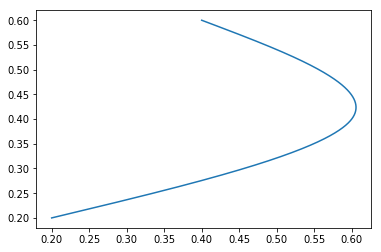

In [42]:
base = bs(np.linspace(0,1,3),df=5,include_intercept=True)
d2t = np.diff(bs(np.linspace(0,1,1000),df=5,include_intercept=True),
                 axis=0) / 1e-3
d2t = np.diff(d2t, axis=0) / 1e-2
bb = np.array([[0.2,0.2],[0.6,0.4],[0.4,0.6]])
A = np.concatenate([d2t.T @ d2t,base],axis=0)
B = np.concatenate([base.T,0*np.eye(3)],axis=0)
D = np.concatenate([A,B],axis=1)
C = np.concatenate([np.zeros((5,2)),bb],axis=0)
beta = np.linalg.solve(D,C)[:5,:]
pts = bs(np.linspace(0,1,1000),df=5,include_intercept=True) @ beta
plt.plot(pts[:,0],pts[:,1])
plt.show()

In [43]:
d2t[:5,:]

array([[ 2.39999278e+00, -3.59878556e+00,  1.19758918e+00,
         1.20360721e-03,  0.00000000e+00],
       [ 2.39517835e+00, -3.59036031e+00,  1.19277475e+00,
         2.40721442e-03,  0.00000000e+00],
       [ 2.39036392e+00, -3.58193506e+00,  1.18796032e+00,
         3.61082164e-03,  0.00000000e+00],
       [ 2.38554949e+00, -3.57350981e+00,  1.18314589e+00,
         4.81442885e-03,  0.00000000e+00],
       [ 2.38073507e+00, -3.56508456e+00,  1.17833146e+00,
         6.01803606e-03,  0.00000000e+00]])